In [1]:
# Auto reload of modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Import
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, pinvh

from rates.auxillary import (
    connected_component,
    drop_entries,
    label_graph,
    cat2one_hot
)
from rates.config import SAVE_DIR
from rates.datasets import circles, mixture
from rates.architectures import exp_kernel

# Config
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
plt.rc('font', size=10, family='serif', serif='cm')

noise_level = 0
# circles = mixture
# noise_level = .3


In [3]:
sigma = .2
lambd = 1e-3

In [4]:
n_train = 100
d = 4
n_test = 1000

x_test, y_test = circles(n_test, d=d, noise_level=noise_level, labels=True, test=True)
one_hot = cat2one_hot(y_test.astype(int) - 1)

In [5]:
ps = np.linspace(.5, 1, 20)
nb_trials = 100
errors = np.empty((nb_trials, len(ps)))
con_comps = np.empty(errors.shape)

for i in range(nb_trials):
    x, y = circles(n_train, d=d, noise_level=noise_level, labels=True, test=False)
    K = exp_kernel(x, x, sigma=sigma)
    K_test = exp_kernel(x_test, x, sigma=sigma)
    T = label_graph(y)

    K_inv = pinvh(K, atol=1e-5 / n_train)
    K_inv *= lambd

    tmp_x = K_test @ K_inv

    for j, p in enumerate(ps):
        T_l = drop_entries(T, p)
        con_comps[i, j] = connected_component(T_l)
        T_l -= K_inv
        w, v = eigh(T_l, subset_by_index=[len(T_l) - 5, len(T_l) - 1])
        
        phi = tmp_x @ v
        w = np.linalg.solve(phi.T @ phi, phi.T @ one_hot)
        pred = np.argmax(phi @ w, axis=1)
        errors[i, j] = (pred + 1 != y_test).mean()
    

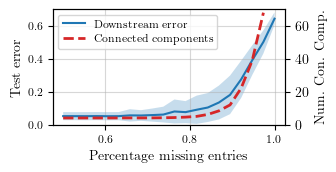

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
a, = ax.plot(ps, errors.mean(axis=0), label="VICReg full graph")
ax.fill_between(ps, errors.mean(axis=0) - errors.std(axis=0), errors.mean(axis=0) + errors.std(axis=0), alpha=.25)

ax2 = ax.twinx()
tmp = con_comps.mean(axis=0)
tmp = tmp
cut = 19
b, = ax2.plot(ps[:cut], tmp[:cut], label="Connected components", linewidth=2, c='C3', linestyle="--")

ax.set_xlabel("Percentage missing entries")
ax.set_ylabel("Test error")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(8)
ax2.set_ylabel("Num. Con. Comp.")
ax.set_ylim(0, .7)
ax2.set_ylim(0, 70)
ax.legend([a, b], ["Downstream error", "Connected components"], fontsize=8, loc="upper left", frameon=True)
ax.grid(alpha=.5)
# fig.savefig(SAVE_DIR / "missing_entries.pdf", bbox_inches='tight', pad_inches=0)